In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import streak_cut as sc
import gradient_image as gi
import numpy as np
import matplotlib.pyplot as plt
import utils
import pandas as pd
import os
from tqdm import tqdm as tqdm
import astropy.io.fits as fits



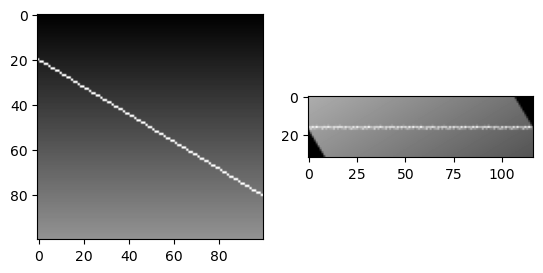

In [6]:
width = 100
height = 100
point1 = (99, 80)
point2 = (0,20)
img = gi.create_gradient_image_with_line(height, width, point1, point2)
cut = sc.cut_around_line(img, point1, point2, 32)
ax, fig = plt.subplots(1, 2)
fig[0].imshow(img, cmap='gray')
fig[1].imshow(cut, cmap='gray')
plt.show()



In [30]:
streaks_csv = utils.read_streaks_csv()


In [103]:
# Sort through r_SDSS.correlated_streaks.csv and add astred.cal.fits to the file name if it is needed

correlated_df = pd.read_csv('data/r_SDSS.correlated_streaks.csv')
for index, row in correlated_df.iterrows():
    path = utils.get_fits_path(row['file_name'], True)
    name = path.split('/')[-1]
    correlated_df.at[index, 'file_name'] = name
correlated_df.to_csv('data/r_SDSS.correlated_streaks_fixed.csv', index=False)



In [104]:
# Aggregate all .streaks files into a single CSV file

# Define the root directory of the project
root_dir = os.path.join('/media/dofri/OBSERVATIONS/VST_BUFFER/')

# List to hold individual dataframes
dataframes = []

type_1 = ['#extension', 'start_x',     'start_y',    'end_x',     'end_y',      'start_ra',      'start_dec',     'end_ra',      'end_dec',      'mjd_start',     'mjd_end']
type_2 = ['extension', 'x_start[px]', 'y_start[px]','x_end[px]', 'y_end[px]',  'ra_start[deg]', 'dec_start[deg]','ra_end[deg]', 'dec_end[deg]', 'JD_start[UTC]', 'JD_end[UTC]']
column_mapping = dict(zip(type_1, type_2))


# Walk through the directory structure
for subdir, dirs, files in os.walk(root_dir):
    # Skip directories named 'L1_DETECTION'
    if 'L1_DETECTION' in subdir:
        continue
    
    for file in files:
        # Check if the file has the extension '.fits.streaks'
        if file.endswith('.fits.streaks'):
            file_path = os.path.join(subdir, file)
            
            # Read the .streaks file into a dataframe
            df = pd.read_csv(file_path)
            file_name = file[:-8]
            df.insert(0, 'file_name', file[:-8])
            # df.insert(1, 'file_path', subdir)
            # Remove the time_method column if it exists
            if ' time_method' in df.columns:
                df.drop(columns=[' time_method'], inplace=True)
            df.rename(columns=column_mapping, inplace=True)
            # Append the dataframe to the list
            dataframes.append(df)

# Concatenate all dataframes into a single dataframe
combined_df = pd.concat(dataframes, ignore_index=True)


# Save the combined dataframe to a single CSV file
combined_df.to_csv('combined_streaks.csv', index=False)

print(combined_df.columns)

print("All CSV files have been successfully concatenated into 'combined_streaks.csv'")

#count the number of rows with no nans or nulls or empty strings except for 'time_method'
print(combined_df.dropna().shape[0])
# Create histogram for each column
# for column in combined_df.columns:
#     if column in ['file_name', 'file_path']:
#         continue
#     combined_df[column].hist()
#     plt.title(column)
#     plt.show()

Index(['file_name', 'extension', 'ID', 'x_start[px]', 'y_start[px]',
       'x_end[px]', 'y_end[px]', 'ra_start[deg]', 'dec_start[deg]',
       'ra_end[deg]', 'dec_end[deg]', 'JD_start[UTC]', 'JD_end[UTC]',
       'norad_number', 'angle_offset[deg]', 'pixel_offset[px]', 'range[m]',
       'phase_angle[deg]', 'ang_vel[deg/s]'],
      dtype='object')
All CSV files have been successfully concatenated into 'combined_streaks.csv'
110


In [111]:
# Compare and combine the aggregated streaks with the correlated streaks, using the data from the aggregated streaks as the primary data source.
# Now realizing that I only end up using the data from one source so a lot of this is redundant but oh well.

combined_df = pd.read_csv('combined_streaks.csv')
correlated_df = pd.read_csv('data/r_SDSS.correlated_streaks_fixed.csv')
match_columns = ['file_name', 'extension', 'ID']
merged_df = pd.merge(combined_df, correlated_df, on=match_columns, suffixes=('_df1', '_df2'), how='outer', indicator=True)
# Find differences between other columns
difference_columns = [col for col in combined_df.columns if col not in match_columns]
zipped_columns = []
for col in difference_columns:
    zipped_columns.append(f'{col}_df1')
    zipped_columns.append(f'{col}_df2')

# Include the matching columns at the start
final_columns_order = match_columns + zipped_columns
merged_df = merged_df[final_columns_order]
print(merged_df.columns)

merged_df.to_csv('comparison.csv', index=False)
print("Saved comparison to 'comparison.csv'")

def find_diff(col1, col2):
    return merged_df[ (merged_df[col1] != merged_df[col2]) 
                     & merged_df[col1].notna() 
                     & merged_df[col2].notna()][[col1, col2]]

columns_of_interest = ['x_start[px]', 'y_start[px]', 'x_end[px]', 'y_end[px]', 'ang_vel[deg/s]']

# for col in columns_of_interest:
#     diff = find_diff(f'{col}_df1', f'{col}_df2')
#     if not diff.empty:
#         print(f"Differences in column '{col}':")
#         print(diff)
#         
# Save the columns of interest to a new CSV file with file_name, extension and ID. Prioritize the first dataframe in the case of a difference
new_df = merged_df[['file_name', 'extension', 'ID']].copy()
print(merged_df.columns)
new_df.insert(3, 'x_start[px]', merged_df['x_start[px]_df2'])
new_df.insert(4, 'y_start[px]', merged_df['y_start[px]_df2'])
new_df.insert(5, 'x_end[px]', merged_df['x_end[px]_df2'])
new_df.insert(6, 'y_end[px]', merged_df['y_end[px]_df2'])
new_df.insert(7, 'ang_vel[deg/s]', merged_df['ang_vel[deg/s]_df2'])
# Throw away any rows with NaN values
new_df.dropna(inplace=True)
new_df.to_csv('good_data.csv', index=False)


# # Print differences between matching row
# 
# # Print differences between matching rows
# for col in difference_columns:
#     diff = merged_df[f'{col}_df1'] != merged_df[f'{col}_df2']
#     differing_rows = merged_df[diff]
#     if not differing_rows.empty:
#         print(f"Differences in column '{col}':")
#         print(differing_rows[[f'{col}_df1', f'{col}_df2', *match_columns]])
# 
# print("Comparison complete.")
# Math by file_name, extention and ID. Print differences in other columns


Index(['file_name', 'extension', 'ID', 'x_start[px]_df1', 'x_start[px]_df2',
       'y_start[px]_df1', 'y_start[px]_df2', 'x_end[px]_df1', 'x_end[px]_df2',
       'y_end[px]_df1', 'y_end[px]_df2', 'ra_start[deg]_df1',
       'ra_start[deg]_df2', 'dec_start[deg]_df1', 'dec_start[deg]_df2',
       'ra_end[deg]_df1', 'ra_end[deg]_df2', 'dec_end[deg]_df1',
       'dec_end[deg]_df2', 'JD_start[UTC]_df1', 'JD_start[UTC]_df2',
       'JD_end[UTC]_df1', 'JD_end[UTC]_df2', 'norad_number_df1',
       'norad_number_df2', 'angle_offset[deg]_df1', 'angle_offset[deg]_df2',
       'pixel_offset[px]_df1', 'pixel_offset[px]_df2', 'range[m]_df1',
       'range[m]_df2', 'phase_angle[deg]_df1', 'phase_angle[deg]_df2',
       'ang_vel[deg/s]_df1', 'ang_vel[deg/s]_df2'],
      dtype='object')
Saved comparison to 'comparison.csv'
Index(['file_name', 'extension', 'ID', 'x_start[px]_df1', 'x_start[px]_df2',
       'y_start[px]_df1', 'y_start[px]_df2', 'x_end[px]_df1', 'x_end[px]_df2',
       'y_end[px]_df1', '

OMEGA.2022-01-21T01:18:05.558.astred.cal.fits - 22 - 1


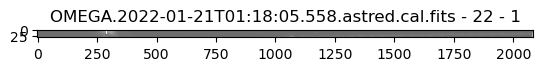

OMEGA.2022-01-27T04:01:24.760.fits - 22 - 5


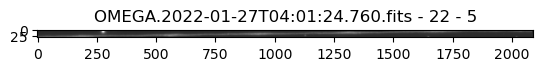

OMEGA.2022-01-07T03:48:30.986.fits - 14 - 2


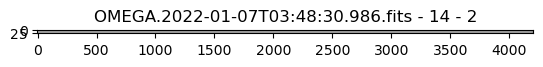

OMEGA.2022-01-30T03:09:26.986.fits - 16 - 1


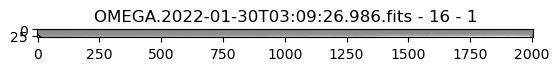

OMEGA.2022-01-29T02:24:16.978.fits - 15 - 5


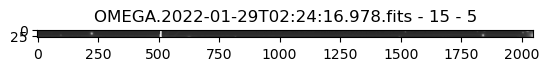

OMEGA.2022-01-05T06:36:26.320.fits - 26 - 7


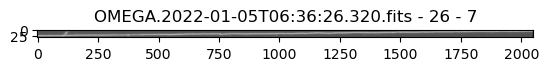

OMEGA.2022-01-10T01:23:14.692.fits - 4 - 7


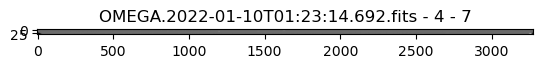

OMEGA.2022-01-08T04:30:31.115.astred.cal.fits - 7 - 6


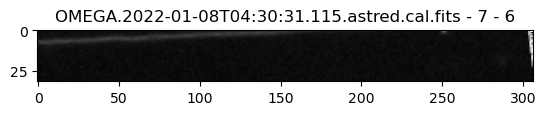

OMEGA.2022-01-27T02:24:18.744.fits - 13 - 1


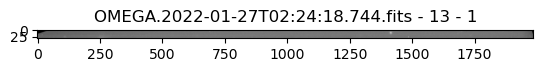

OMEGA.2022-01-31T05:26:59.419.fits - 27 - 6


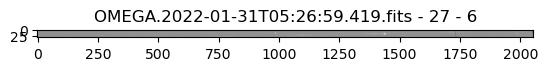

In [189]:
good_data = pd.read_csv('good_data.csv') 

# pick 10 random rows
sample = good_data.sample(10)
for index, row in sample.iterrows():
    file_path = utils.get_fits_path(row['file_name'], True)
    with fits.open(file_path) as hdul:
        data = hdul[row['extension']].data
        start = (row['x_start[px]'], row['y_start[px]'])
        end = (row['x_end[px]'], row['y_end[px]'])
        cut = sc.cut_around_line(data, start, end, 32)[:,:]
        # # Display the cut along with a histogram of the cut
        # ax, fig = plt.subplots(1, 2)
        # fig[0].imshow(cut, cmap='gray')
        # # histogram in log scale
        # fig[1].hist(cut.flatten(), bins=256, log=True)
        plt.imshow(cut, cmap='gray', norm=utils.LogNorm())
        title = f"{row['file_name']} - {row['extension']} - {row['ID']}"
        plt.title(title)
        print(title)
        plt.show()
        

                                         file_name  extension  ID  \
273  OMEGA.2022-01-08T04:30:31.115.astred.cal.fits          7   6   
274  OMEGA.2022-01-08T04:30:31.115.astred.cal.fits          8   7   
275  OMEGA.2022-01-08T04:30:31.115.astred.cal.fits         22   2   
276  OMEGA.2022-01-08T04:30:31.115.astred.cal.fits         23   3   
277  OMEGA.2022-01-08T04:30:31.115.astred.cal.fits         24   4   

     x_start[px]  y_start[px]  x_end[px]  y_end[px]  ang_vel[deg/s]  
273       1792.0        635.9     2096.0      672.4        0.002385  
274         48.0        640.6     2096.0      832.6        0.002386  
275         48.0        960.9     2096.0     1120.8        0.002390  
276         48.0       1121.1     2096.0     1281.0        0.002392  
277         48.0       1281.2     2096.0     1441.2        0.002394  
Start: (1792, 635), End: (2096, 672)


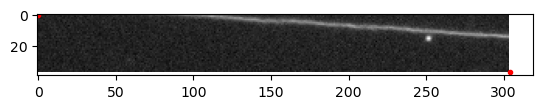

In [199]:
# utils.show_streak_with_endpoints('OMEGA.2022-01-05T06:08:00.955.fits', 19, 1, True)
utils.show_streak_with_endpoints('OMEGA.2022-01-08T04:30:31.115.astred.cal.fits', 7, 6, True)

In [172]:
good_data = pd.read_csv('good_data.csv')
# get first row
row = good_data.iloc[1]
bzero_counts = {}

for idx, row in good_data.iterrows():
    with fits.open(utils.get_fits_path(row['file_name'], True)) as hdul:
        # print the extension metadata
        # print(hdul[0].header)
        # hdul.info()
        # for i in range(1, len(hdul)):
        i = 1
        if hdul[i].header['BZERO'] in bzero_counts.keys():
            bzero_counts[hdul[i].header['BZERO']] += 1
        else:
            bzero_counts[hdul[i].header['BZERO']] = 1
        # if hdul[i].header['BSCALE'] != 1.0:
        #     print(row['file_name'] + " BSCALE[" + str(i) + "]: " + str(hdul[i].header['BSCALE']))
        # if hdul[i].header['BZERO'] != 32768:
        #     print(row['file_name'] + " BZERO[" + str(i) + "]: " + str(hdul[i].header['BZERO']))

print(bzero_counts)

KeyError: "Keyword 'BUNIT' not found."

In [206]:
good_data = pd.read_csv('good_data.csv')
# get first row
row = good_data.iloc[1]
bzero_counts = {}

with fits.open(utils.get_fits_path(row['file_name'], True)) as hdul:
    print(hdul[1].data.shape)
    print(hdul[0].header.keys)

(4200, 2144)
<bound method Header.keys of SIMPLE  =                    T          / Standard FITS format (NOST-100.0)     
BITPIX  =                   16          / # of bits storing pix values          
NAXIS   =                    0          / # of axes in frame                    
EXTEND  =                    T / Extension may be present                       
ORIGIN  = 'ESO-PARANAL'                 / European Southern Observatory         
DATE    = '2023-10-23T11:19:33' / File Creation date                            
TELESCOP= 'ESO-VST '                    / ESO Telescope Name                    
INSTRUME= 'OMEGACAM'                    / Instrument used.                      
OBJECT  = 'STD,ZEROPOINT'      / Original target.                               
RA      =            13.800000          / 00:55:12.0 RA (J2000) pointing (deg)  
DEC     =              0.93278          / 00:55:58.0 DEC (J2000) pointing (deg) 
EQUINOX =                2000.          / Standard FK5 (years)     

 [astropy.io.fits.verify]


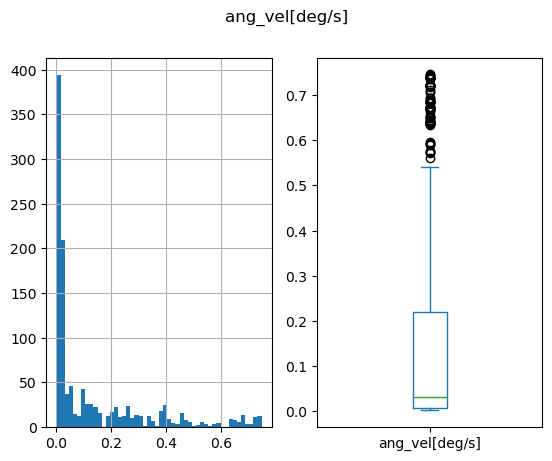

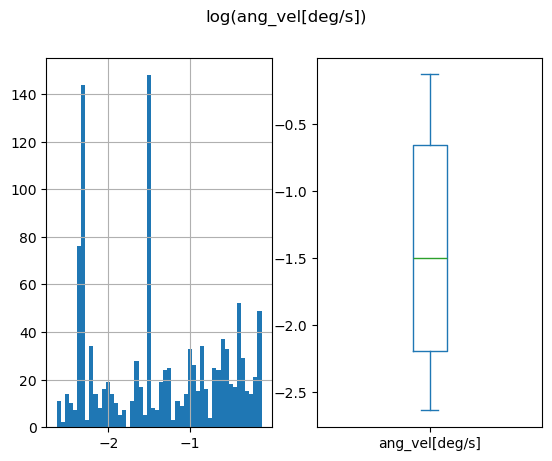

In [243]:
good_data = pd.read_csv('good_data.csv')

# Create a histogram and boxplot of the ang_vel[deg/s] column in a subplot
fig, ax = plt.subplots(1, 2)
good_data['ang_vel[deg/s]'].hist(ax=ax[0], bins=50)
good_data['ang_vel[deg/s]'].plot(kind='box', ax=ax[1])
fig.suptitle('ang_vel[deg/s]')
plt.show()

# Create a histogram and boxplot of the log(ang_vel[deg/s]) column
log_ang_vel = np.log10(good_data['ang_vel[deg/s]'])
fig, ax = plt.subplots(1, 2)
log_ang_vel.hist(ax=ax[0], bins=50)
log_ang_vel.plot(kind='box', ax=ax[1])
fig.suptitle('log(ang_vel[deg/s])')
plt.show()

-1.3698193225848714
0.7541695564718683
9.593825968068863e-17


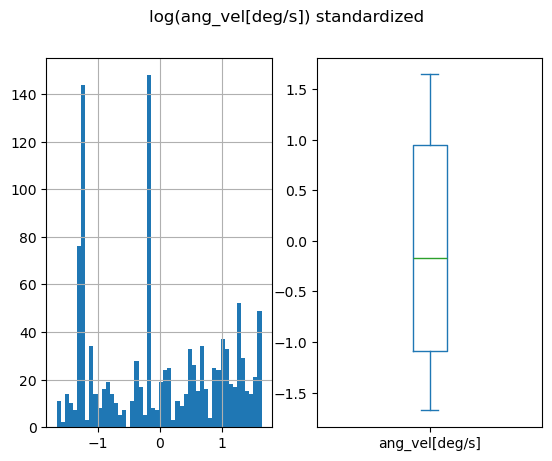

In [241]:
# Scale and translate log_ang_vel so the mean is 0 and the standard deviation is 1
print(log_ang_vel.mean())
print(log_ang_vel.std())
log_ang_vel_standardized = (log_ang_vel - log_ang_vel.mean()) / log_ang_vel.std()
print(log_ang_vel_standardized.mean())
# Create a histogram and boxplot of the scaled log(ang_vel[deg/s]) column
fig, ax = plt.subplots(1, 2)
log_ang_vel_standardized.hist(ax=ax[0], bins=50)
log_ang_vel_standardized.plot(kind='box', ax=ax[1])
fig.suptitle('log(ang_vel[deg/s]) standardized')
plt.show()

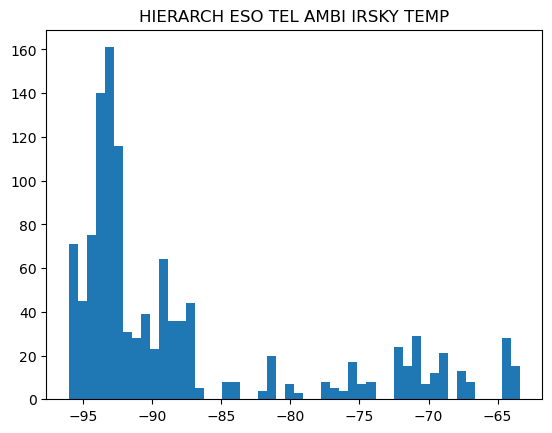

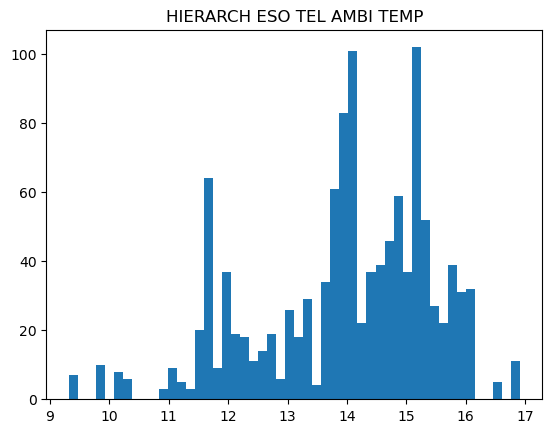

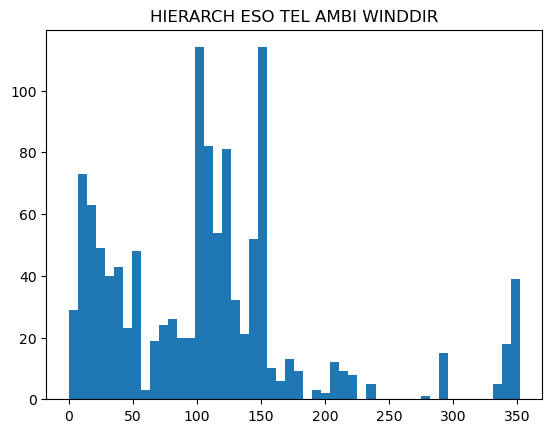

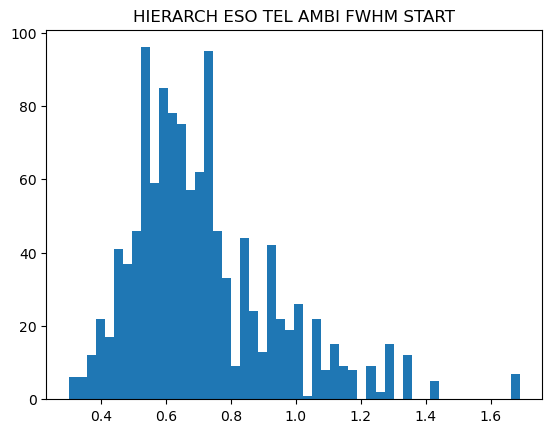

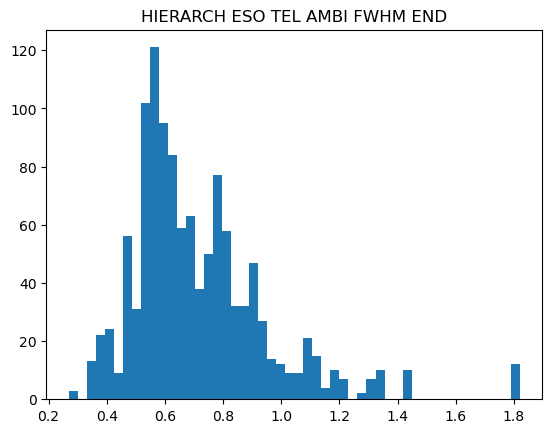

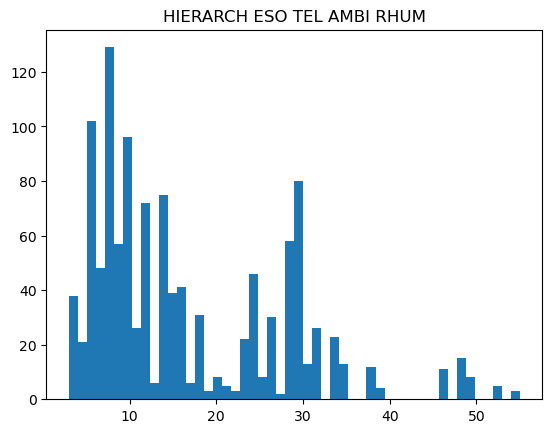

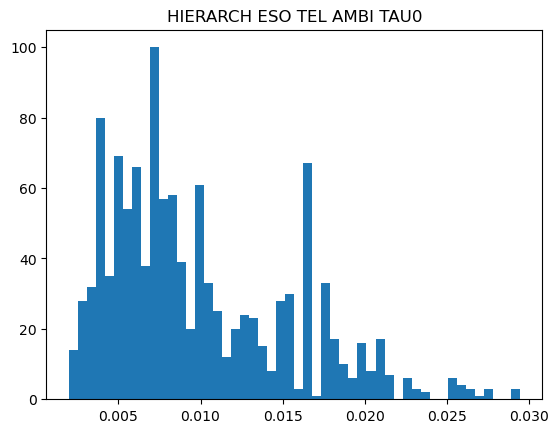

In [245]:
# Look at the distribution of fits metadata
good_data = pd.read_csv('good_data.csv')
keys_of_interest = ['HIERARCH ESO TEL AMBI IRSKY TEMP',
                    'HIERARCH ESO TEL AMBI TEMP',
                    'HIERARCH ESO TEL AMBI WINDDIR',
                    'HIERARCH ESO TEL AMBI WINDSP'
                    'HIERARCH ESO TEL AMBI PRES START',
                    'HIERARCH ESO TEL AMBI FWHM START',
                    'HIERARCH ESO TEL AMBI FWHM END',
                    'HIERARCH ESO TEL AMBI RHUM',
                    'HIERARCH ESO TEL AMBI TAU0'
]
key_data = {}                

for idx, row in good_data.iterrows():
    with fits.open(utils.get_fits_path(row['file_name'], True)) as hdul:
        for key in keys_of_interest:
            if key in hdul[0].header:
                if key in key_data.keys():
                    key_data[key].append(hdul[0].header[key])
                else:
                    key_data[key] = [hdul[0].header[key]]

# Show histograms for each key
for key, data in key_data.items():
    plt.hist(data, bins=50)
    plt.title(key)
    plt.show()

1185it [06:28,  3.05it/s]


Text(0.5, 1.0, 'Pixel Value Histogram')

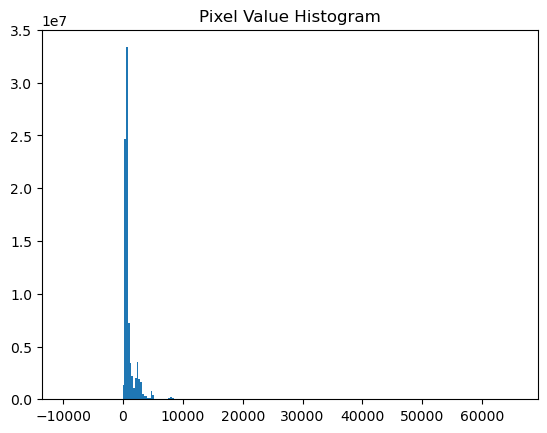

In [248]:

good_data = pd.read_csv('good_data.csv')

# Get all of the images and create a histogram of the total pixel values of all images
with fits.open(utils.get_fits_path(good_data.iloc[0]['file_name'], True)) as hdul:
    (height, width) = hdul[1].data.shape
pixels = np.zeros((1,))

for(idx, streak) in tqdm(good_data.iterrows()):
    streakName = streak["file_name"]
    extension = streak["extension"]
    with fits.open(utils.get_fits_path(streakName, True)) as hdul:
        streak_x_start = streak["x_start[px]"]
        streak_y_start = streak["y_start[px]"]
        streak_x_end = streak["x_end[px]"]
        streak_y_end = streak["y_end[px]"]
        cut_flat = sc.cut_around_line(hdul[extension].data, (streak_x_start, streak_y_start), (streak_x_end, streak_y_end), 32).flatten()
        pixels = np.concatenate((pixels, cut_flat))

                
        

Text(0.5, 1.0, 'Pixel Value Histogram')

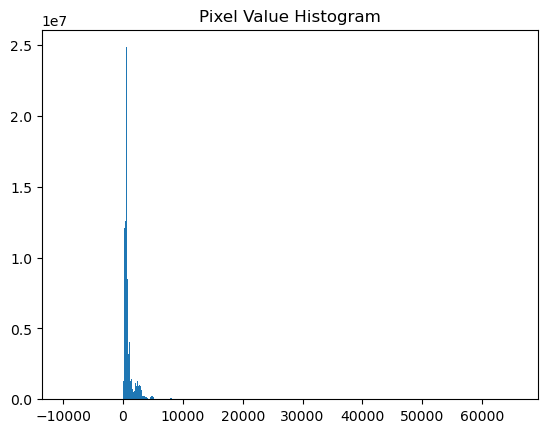

In [272]:
plt.hist(pixels, bins=512)
plt.title("Pixel Value Histogram")


/tmp/ipykernel_295342/2848422805.py:6: RuntimeWarning: invalid value encountered in log10
  log_pixels_nonzero = np.log10(pixels_nonzero)


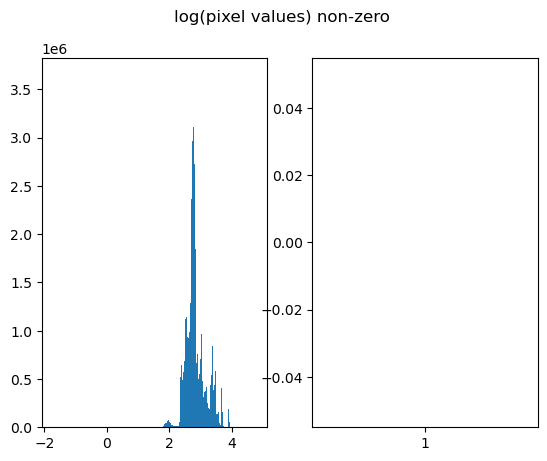

In [270]:

# Get indices of non-zero elements
nonzero_indices = np.nonzero(pixels)

# Remove zero-valued elements
pixels_nonzero = pixels[nonzero_indices]
log_pixels_nonzero = np.log10(pixels_nonzero)

# Create a histogram and boxplot of the log of the non-zero pixel values
fig, ax = plt.subplots(1, 2)
ax[0].hist(log_pixels_nonzero, bins=500)
ax[1].boxplot(log_pixels_nonzero)
fig.suptitle('log(pixel values) non-zero')
plt.show()

/home/dofri/miniconda3/envs/semester_project/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/dofri/miniconda3/envs/semester_project/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

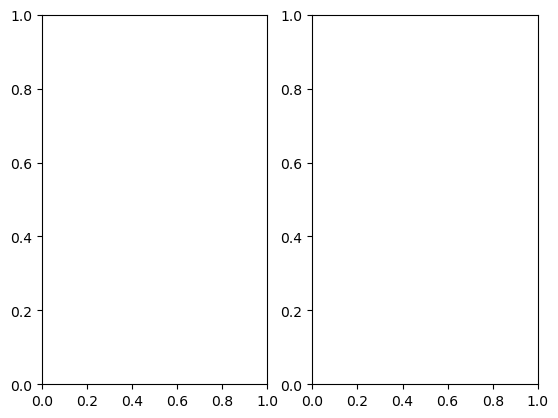

In [259]:
pixels_standardized = (log_pixels_nonzero - log_pixels_nonzero.mean()) / log_pixels_nonzero.std()
fig, ax = plt.subplots(1, 2)
ax[0].hist(pixels_standardized, bins=100)
ax[1].boxplot(pixels_standardized)
fig.suptitle('log(pixel values) standardized')
plt.show()

In [274]:

max_pixel = pixels.max()
min_pixel = pixels.min()
mean_pixel = pixels.mean()
median_pixel = np.median(pixels)
std_pixel = pixels.std()
max_count = np.count_nonzero(pixels == max_pixel)
min_count = np.count_nonzero(pixels == min_pixel)
negative_count = np.count_nonzero(pixels < 0)
print(f"Max pixel value: {max_pixel}, count: {max_count}")
print(f"Min pixel value: {min_pixel}, count: {min_count}")
print(f"Negative pixel value count: {negative_count}. That's {negative_count / pixels.size * 100}% of the pixels.")
print(f"Mean pixel value: {mean_pixel}")
print(f"Median pixel value: {median_pixel}")
print(f"Standard deviation of pixel values: {std_pixel}")

Max pixel value: 65535.0, count: 10947
Min pixel value: -9787.46875, count: 1
Negative pixel value count: 50672. That's 0.05913454000611161% of the pixels.
Mean pixel value: 1005.5413113987076
Median pixel value: 609.0
Standard deviation of pixel values: 1391.856173548186


In [ ]:
good_data = pd.read_csv('good_data.csv')

for idx, row in tqdm(good_data.iterrows(), total=good_data.shape[0]):
    caught_error = False

    with fits.open(utils.get_fits_path(row['file_name'], True), memmap=False, lazy_load_hdus=True) as hdul:
        for i in range(1, len(hdul)):
            try:
                if hdul[i].header['BZERO'] != 32768.0:
                    tqdm.write("HI")
            except KeyError:
                print(f"KeyError: {row['file_name']} - {i}")
                print(hdul[i].header)
                caught_error = True
                break
    if caught_error:
        break

In [6]:
# This cell verifies that all the files in the good_data.csv file are present in the directory structure
good_data = pd.read_csv('good_data.csv')
missing_files = []
for idx, row in tqdm(good_data.iterrows(), total=good_data.shape[0]):
    if not os.path.exists(utils.get_fits_path(row['file_name'], False)):
        missing_files.append(row['file_name'])
if len(missing_files) == 0:
    print("All files are present.")
else:
    print(f"Missing files: {missing_files}")

100%|██████████| 1185/1185 [00:00<00:00, 8185.40it/s]

All files are present.


In [60]:
good_data = pd.read_csv('good_data.csv')
file_names = good_data['file_name'].unique()

for idx, file_name in tqdm(enumerate(file_names[:50]), total=50):
    with fits.open(utils.get_fits_path(file_name, True), mode='update', output_verify='fix', memmap=True) as hdul:
        for i in range(1, len(hdul)):
            if hdul[i].header['BZERO'] != 32768.0:
                hdul[i].header['BZERO'] = 32768.0
                hdul.flush()

100%|██████████| 50/50 [02:11<00:00,  2.64s/it]


In [61]:
good_data = pd.read_csv('good_data.csv')
file_names = good_data['file_name'].unique()

for idx, file_name in tqdm(enumerate(file_names[50:100]), total=50):
    with fits.open(utils.get_fits_path(file_name, True), mode='update', output_verify='fix', memmap=True) as hdul:
        for i in range(1, len(hdul)):
            if hdul[i].header['BZERO'] != 32768.0:
                hdul[i].header['BZERO'] = 32768.0
                hdul.flush()

100%|██████████| 50/50 [02:10<00:00,  2.61s/it]


In [63]:
good_data = pd.read_csv('good_data.csv')
file_names = good_data['file_name'].unique()

for idx, file_name in tqdm(enumerate(file_names[100:150]), total=50):
    try:
        with fits.open(utils.get_fits_path(file_name, True), mode='update', output_verify='fix', memmap=True) as hdul:
            for i in range(1, len(hdul)):
                if hdul[i].header['BZERO'] != 32768.0:
                    hdul[i].header['BZERO'] = 32768.0
                    hdul.flush()
    except Exception as e:
        print(f"Error in file {file_name}: {e}")

 66%|██████▌   | 33/50 [01:10<00:23,  1.37s/it]WARNING: File may have been truncated: actual file length (540704768) is smaller than the expected size (558587520) [astropy.io.fits.file]
 [astropy.io.fits.verify]
 68%|██████▊   | 34/50 [01:13<00:24,  1.56s/it]

Error in file OMEGA.2022-01-23T03:36:39.644.fits: buffer is too small for requested array


100%|██████████| 50/50 [01:53<00:00,  2.27s/it]


In [87]:
path = 'data/sandbox/OMEGA.2022-01-23T03:36:39.644.fits'
with fits.open(path, mode='update', output_verify='fix') as hdul:
    for i in range(1, len(hdul)):
        if hdul[i].header['BZERO'] != 32768.0:
            hdul[i].header['BZERO'] = 32768.0
            hdul.flush()

In [104]:
file_names = pd.read_csv('good_data.csv')['file_name'].unique()


for file_name in tqdm(file_names, total=file_names.shape[0]):
    drive1_filepath = utils.get_fits_path(file_name, True, drive="MedTina")
    drive2_filepath = utils.get_fits_path(file_name, True, drive="OBSERVATIONS")
    # Check if the filesize is the same
    drive1_size = os.path.getsize(drive1_filepath)
    drive2_size = os.path.getsize(drive2_filepath)
    if drive1_size != drive2_size:
        print(f"File sizes do not match: {file_name}. MedTina: {drive1_size}, OBSERVATIONS: {drive2_size}")
    # Check if the files are the same
    with open(drive1_filepath, 'rb') as file1, open(drive2_filepath, 'rb') as file2:
        if file1.read() != file2.read():
            print(f"Files do not match: {file_name}")

  0%|          | 1/245 [00:07<30:55,  7.61s/it]

Files do not match: OMEGA.2022-01-02T00:35:59.042.astred.cal.fits


  1%|          | 2/245 [00:15<30:50,  7.62s/it]

Files do not match: OMEGA.2022-01-02T00:59:16.697.astred.cal.fits


  1%|          | 3/245 [00:22<30:51,  7.65s/it]

Files do not match: OMEGA.2022-01-02T03:19:53.631.astred.cal.fits


  2%|▏         | 4/245 [00:30<30:40,  7.64s/it]

Files do not match: OMEGA.2022-01-02T06:18:43.121.astred.cal.fits


  2%|▏         | 5/245 [00:37<30:08,  7.54s/it]

Files do not match: OMEGA.2022-01-02T06:30:52.304.astred.cal.fits


  2%|▏         | 6/245 [00:46<31:17,  7.85s/it]

Files do not match: OMEGA.2022-01-03T00:33:56.321.fits


  3%|▎         | 7/245 [00:54<31:51,  8.03s/it]

Files do not match: OMEGA.2022-01-03T01:11:55.387.fits


  3%|▎         | 8/245 [01:03<31:59,  8.10s/it]

Files do not match: OMEGA.2022-01-03T01:18:01.318.fits


  4%|▎         | 9/245 [01:11<31:56,  8.12s/it]

Files do not match: OMEGA.2022-01-03T02:20:08.139.fits


  4%|▍         | 10/245 [01:19<32:15,  8.24s/it]

Files do not match: OMEGA.2022-01-03T04:26:59.650.fits


  4%|▍         | 11/245 [01:27<32:05,  8.23s/it]

Files do not match: OMEGA.2022-01-03T07:26:28.711.fits


  4%|▍         | 11/245 [01:36<34:03,  8.73s/it]


KeyboardInterrupt: 

In [107]:
# Print the file differences
file_name = "OMEGA.2022-01-03T01:11:55.387.fits"
def compare_fits_files_by_path(file_path1, file_path2):
    # Open the two fits files, iterate through the extensions and compare the data and headers
    
    with fits.open(file_path1, do_not_scale_image_data=False) as hdul1, fits.open(file_path2, do_not_scale_image_data=False) as hdul2:
        for i in range(1,2):# len(hdul1)):
            if not np.array_equal(hdul1[i].data, hdul2[i].data):
                print(f"Data in extension {i} does not match.")
            if hdul1[i].header != hdul2[i].header:
                print(f"Headers in extension {i} do not match.")
                keys1 = list(hdul1[i].header.keys())
                keys2 = list(hdul2[i].header.keys())
                if( keys1 != keys2):
                    print(f"Keys in extension {i} do not match.")
                keyMismatch = False
                # for key in keys1:
                #     if key not in keys2:
                #         print(f"Key: {key} not in file 2. Header {i}.")
                #         keyMismatch = True
                # for key in keys2:
                #     if key not in keys1:
                #         print(f"Key: {key} not in file 1. Header {i}.")
                #         keyMismatch = True
                # if keyMismatch:
                #     continue
                # for key in hdul1[i].header.keys():
                #     if hdul1[i].header[key] != hdul2[i].header[key] and key not in ['CHECKSUM', 'DATASUM']:
                #         print(f"Key: {key}, value1: {hdul1[i].header[key]}, value2: {hdul2[i].header[key]}")


def compare_fits_files(file_name):
    drive1_filepath = utils.get_fits_path(file_name, True, drive="MedTina")
    drive2_filepath = utils.get_fits_path(file_name, True, drive="OBSERVATIONS")
    compare_fits_files_by_path(drive1_filepath, drive2_filepath)


In [77]:
def compare_fits_files_by_path_debugA(file_path1, file_path2):
    # Open the two fits files, iterate through the extensions and compare the data and headers

    with fits.open(file_path2, do_not_scale_image_data=False, lazy_load_hdus=False) as hdulist:
        print("File: " + file_path2)
        hdu = hdulist[1]
        # hdu.header.keys()
        keys_a = list(hdu.header.keys())
        keys_b = list(hdu.header.keys())
        print(keys_a)
        if keys_a != keys_b:
            print("Weird")
            # Find the difference in keys
            print(len(list(keys_a)))
            print(len(list(keys_b)))
            for key in keys_a:
                if key not in keys_b:
                    print(f"Key: {key} not in file 2.")
            for key in keys_b:
                if key not in keys_a:
                    print(f"Key: {key} not in file 1.")
            

In [109]:
# Print the file differences

def compare_fits_files_by_path_debugB(file_path1, file_path2):
    # Open the two fits files, iterate through the extensions and compare the data and headers

    with fits.open(file_path1, do_not_scale_image_data=False) as hdul1, fits.open(file_path2, do_not_scale_image_data=False) as hdul2:
        hdu1 = hdul1[1]
        hdu2 = hdul2[1]
        if not np.array_equal(hdul1[i].data, hdul2[i].data):
            print(f"Data in extension {1} does not match.")

        if hdu1.header != hdu2.header:
            print(f"Headers in extension {1} do not match.")
            keys1 = list(hdu1.header.keys())
            keys2 = list(hdu2.header.keys())
            if keys1 != keys2:
                print(f"Keys in extension {1} do not match.")
            for key in keys1:
                if key not in keys2:
                    print(f"Key: {key} not in file 2.")
            for key in keys2:
                if key not in keys1:
                    print(f"Key: {key} not in file 1.")



In [110]:
compare_fits_files_by_path_debugB(astred_path, astred_backup_path)


NameError: name 'i' is not defined

In [108]:
compare_fits_files_by_path(astred_path, astred_backup_path)

Data in extension 1 does not match.
Headers in extension 1 do not match.
Keys in extension 1 do not match.


In [151]:
do_not_scale_image_data = False 
def try_print_key(hdu, key):
    try:
        print(key, ":", hdu.header[key])
    except KeyError:
        print(f"KeyError: {key}")

def print_relevant_keys(hdu):
    keys = ['BZERO', 'BSCALE', 'BITPIX']
    for key in keys:
        try_print_key(hdu, key)

with fits.open(astred_path, do_not_scale_image_data=do_not_scale_image_data) as hdul:
    print("Astred")
    print_relevant_keys(hdul[1])
    print("Data 0,0: ", hdul[1].data[0,0])
    print_relevant_keys(hdul[1])
with fits.open(astred_backup_path, do_not_scale_image_data=do_not_scale_image_data) as hdul:
    print("Astred Backup")
    print_relevant_keys(hdul[1])
    print("Data 0,0: ", hdul[1].data[0,0])
    print_relevant_keys(hdul[1])
with fits.open(non_astred_path, do_not_scale_image_data=do_not_scale_image_data) as hdul:
    print("Non-Astred")
    print_relevant_keys(hdul[1])
    print("Data 0,0: ", hdul[1].data[0,0])
    print_relevant_keys(hdul[1])
with fits.open(copy_path_scale, do_not_scale_image_data=do_not_scale_image_data) as hdul:
    print("Copy Scale")
    print_relevant_keys(hdul[1])
    print("Data 0,0: ", hdul[1].data[0,0])
    print_relevant_keys(hdul[1])
with fits.open(copy_path_no_scale, do_not_scale_image_data=do_not_scale_image_data) as hdul:
    print("Copy No Scale")
    print_relevant_keys(hdul[1])
    print("Data 0,0: ", hdul[1].data[0,0])
    print_relevant_keys(hdul[1])

Astred
BZERO : 32768.0
BSCALE : 1.0
BITPIX : 16
Data 0,0:  6045
BZERO : 32768.0
BSCALE : 1.0
BITPIX : 16
Astred Backup
BZERO : 22768
BSCALE : 1.0
BITPIX : 16
Data 0,0:  -3955.0
KeyError: BZERO
KeyError: BSCALE
BITPIX : -32
Non-Astred
BZERO : 32768.0
BSCALE : 1.0
BITPIX : 16
Data 0,0:  275
BZERO : 32768.0
BSCALE : 1.0
BITPIX : 16
Copy Scale
BZERO : 32768
BSCALE : 1
BITPIX : 16
Data 0,0:  6045
BZERO : 32768
BSCALE : 1
BITPIX : 16
Copy No Scale
BZERO : 32768.0
BSCALE : 1.0
BITPIX : 16
Data 0,0:  6045
BZERO : 32768.0
BSCALE : 1.0
BITPIX : 16


In [ ]:
file_names = pd.read_csv('good_data.csv')['file_name'].unique()
for file_name in tqdm(file_names, total=file_names.shape[0]):
    compare_fits_files(file_name)

In [9]:
def fix_bzero(file_path):
    with fits.open(file_path, mode='update', output_verify='ignore', memmap=True, do_not_scale_image_data=True) as hdul:
        for i in range(1, len(hdul)):
            if hdul[i].header['BZERO'] != 32768.0:
                hdul[i].header['BZERO'] = 32768.0
        hdul.flush()

In [129]:
def fix_bezero_and_save_as_copy(file_path, new_file_path, do_not_scale_image_data):
    with fits.open(file_path, mode='readonly', output_verify='ignore', memmap=False, do_not_scale_image_data=do_not_scale_image_data) as hdul:
        for i in range(1, len(hdul)):
            if hdul[i].header['BZERO'] != 32768.0:
                hdul[i].header['BZERO'] = 32768.0
        hdul.writeto(new_file_path, overwrite=True)

In [113]:
astred_path = 'data/sandbox/OMEGA.2022-01-02T00:35:59.042.astred.cal.fits'
astred_backup_path = 'data/sandbox/OMEGA.2022-01-02T00:35:59.042.astred.cal_backup.fits'
non_astred_path = 'data/sandbox/OMEGA.2022-01-19T01:58:42.111.fits'
non_astred_backup_path = 'data/sandbox/OMEGA.2022-01-19T01:58:42.111_backup.fits'


fix_bzero(astred_path)
# fix_bzero(non_astred_path)



In [130]:
copy_path_scale = "data/sandbox/OMEGA.2022-01-02T00:35:59.042.astred.cal_fixed_scale.fits"
copy_path_no_scale = "data/sandbox/OMEGA.2022-01-02T00:35:59.042.astred.cal_fixed_no_scale.fits"
fix_bezero_and_save_as_copy(astred_path, copy_path_scale, False)
fix_bezero_and_save_as_copy(astred_path, copy_path_no_scale, True)

100%|██████████| 63/63 [01:55<00:00,  1.84s/it]


In [7]:
# Fix all the astred files by setting BZERO to 32768
good_data = pd.read_csv('good_data.csv')
file_names = good_data['file_name'].unique()
astred_files = [file_name for file_name in file_names if "astred.cal" in file_name]
for file_name in tqdm(astred_files, total=len(astred_files), desc="Fixing astred files", unit="file"):
    tqdm.write(f"Fixing file: {file_name}")
    with fits.open(utils.get_fits_path(file_name, False), mode='update', output_verify='ignore', memmap=False, do_not_scale_image_data=True) as hdul:
        for i in range(1, len(hdul)):
            hdul[i].header['BZERO'] = 32768.0
        hdul.flush()

Fixing astred files:   0%|          | 0/63 [00:00<?, ?file/s]WARNING: VerifyWarning: Verification reported errors: [astropy.io.fits.verify]
 [astropy.io.fits.verify]


Fixing file: OMEGA.2022-01-02T00:35:59.042.astred.cal.fits


Fixing astred files:   2%|▏         | 1/63 [00:05<05:42,  5.53s/file]

Fixing file: OMEGA.2022-01-02T00:59:16.697.astred.cal.fits


Fixing astred files:   3%|▎         | 2/63 [00:10<05:14,  5.16s/file]

Fixing file: OMEGA.2022-01-02T03:19:53.631.astred.cal.fits


Fixing astred files:   5%|▍         | 3/63 [00:15<05:01,  5.02s/file]

Fixing file: OMEGA.2022-01-02T06:18:43.121.astred.cal.fits


Fixing astred files:   6%|▋         | 4/63 [00:20<04:51,  4.95s/file]

Fixing file: OMEGA.2022-01-02T06:30:52.304.astred.cal.fits


Fixing astred files:   8%|▊         | 5/63 [00:25<04:58,  5.15s/file]WARNING: VerifyWarning:         Card 'ESO DET TLM2 END' is not FITS standard (invalid value string: '3.300e-05 / Telemetry value at read completion').  Fixed 'ESO DET TLM2 END' card to meet the FITS standard. [astropy.io.fits.verify]


Fixing file: OMEGA.2022-01-04T01:11:08.716.astred.cal.fits


Fixing astred files:  10%|▉         | 6/63 [00:30<04:51,  5.11s/file]

Fixing file: OMEGA.2022-01-04T01:17:13.178.astred.cal.fits


Fixing astred files:  11%|█         | 7/63 [00:35<04:45,  5.10s/file]

Fixing file: OMEGA.2022-01-04T01:49:30.183.astred.cal.fits


Fixing astred files:  13%|█▎        | 8/63 [00:41<04:52,  5.31s/file]

Fixing file: OMEGA.2022-01-04T03:08:57.016.astred.cal.fits


Fixing astred files:  14%|█▍        | 9/63 [00:46<04:41,  5.22s/file]

Fixing file: OMEGA.2022-01-04T03:15:01.467.astred.cal.fits


Fixing astred files:  16%|█▌        | 10/63 [00:51<04:32,  5.15s/file]

Fixing file: OMEGA.2022-01-04T03:36:09.901.astred.cal.fits


Fixing astred files:  17%|█▋        | 11/63 [00:57<04:36,  5.32s/file]

Fixing file: OMEGA.2022-01-04T04:12:21.796.astred.cal.fits


Fixing astred files:  19%|█▉        | 12/63 [01:02<04:23,  5.17s/file]WARNING: VerifyWarning:         Card 'ESO DET TLM2 END' is not FITS standard (invalid value string: '3.100e-05 / Telemetry value at read completion').  Fixed 'ESO DET TLM2 END' card to meet the FITS standard. [astropy.io.fits.verify]


Fixing file: OMEGA.2022-01-04T07:54:15.943.astred.cal.fits


Fixing astred files:  21%|██        | 13/63 [01:06<04:13,  5.06s/file]

Fixing file: OMEGA.2022-01-04T08:00:20.403.astred.cal.fits


Fixing astred files:  22%|██▏       | 14/63 [01:12<04:11,  5.14s/file]

Fixing file: OMEGA.2022-01-04T08:12:29.356.astred.cal.fits


Fixing astred files:  24%|██▍       | 15/63 [01:17<04:03,  5.07s/file]WARNING: VerifyWarning:         Card 'ESO DET TLM2 END' is not FITS standard (invalid value string: '3.000e-05 / Telemetry value at read completion').  Fixed 'ESO DET TLM2 END' card to meet the FITS standard. [astropy.io.fits.verify]


Fixing file: OMEGA.2022-01-06T01:17:50.898.astred.cal.fits


Fixing astred files:  25%|██▌       | 16/63 [01:21<03:55,  5.01s/file]

Fixing file: OMEGA.2022-01-06T02:13:19.028.astred.cal.fits


Fixing astred files:  27%|██▋       | 17/63 [01:27<03:55,  5.11s/file]

Fixing file: OMEGA.2022-01-06T02:19:23.658.astred.cal.fits


Fixing astred files:  29%|██▊       | 18/63 [01:32<03:47,  5.06s/file]

Fixing file: OMEGA.2022-01-06T02:57:46.595.astred.cal.fits


Fixing astred files:  30%|███       | 19/63 [01:37<03:40,  5.02s/file]

Fixing file: OMEGA.2022-01-06T03:03:51.066.astred.cal.fits


Fixing astred files:  32%|███▏      | 20/63 [01:42<03:45,  5.23s/file]

Fixing file: OMEGA.2022-01-06T03:27:46.260.astred.cal.fits


Fixing astred files:  33%|███▎      | 21/63 [01:47<03:35,  5.12s/file]WARNING: VerifyWarning:         Card 'ESO DET TLM2 END' is not FITS standard (invalid value string: '2.800e-05 / Telemetry value at read completion').  Fixed 'ESO DET TLM2 END' card to meet the FITS standard. [astropy.io.fits.verify]


Fixing file: OMEGA.2022-01-06T06:06:38.127.astred.cal.fits


Fixing astred files:  35%|███▍      | 22/63 [01:52<03:30,  5.14s/file]

Fixing file: OMEGA.2022-01-06T06:18:48.449.astred.cal.fits


Fixing astred files:  37%|███▋      | 23/63 [01:58<03:25,  5.13s/file]WARNING: VerifyWarning:         Card 'ESO DET TLM2 END' is not FITS standard (invalid value string: '2.700e-05 / Telemetry value at read completion').  Fixed 'ESO DET TLM2 END' card to meet the FITS standard. [astropy.io.fits.verify]


Fixing file: OMEGA.2022-01-08T01:17:35.453.astred.cal.fits


Fixing astred files:  38%|███▊      | 24/63 [02:02<03:16,  5.03s/file]

Fixing file: OMEGA.2022-01-08T02:47:50.119.astred.cal.fits


Fixing astred files:  40%|███▉      | 25/63 [02:08<03:13,  5.08s/file]

Fixing file: OMEGA.2022-01-08T02:53:55.149.astred.cal.fits


Fixing astred files:  41%|████▏     | 26/63 [02:13<03:07,  5.06s/file]

Fixing file: OMEGA.2022-01-08T03:57:58.470.astred.cal.fits


Fixing astred files:  43%|████▎     | 27/63 [02:17<02:57,  4.94s/file]

Fixing file: OMEGA.2022-01-08T04:24:26.654.astred.cal.fits


Fixing astred files:  44%|████▍     | 28/63 [02:22<02:53,  4.96s/file]

Fixing file: OMEGA.2022-01-08T04:30:31.115.astred.cal.fits


Fixing astred files:  46%|████▌     | 29/63 [02:27<02:48,  4.97s/file]

Fixing file: OMEGA.2022-01-08T07:33:36.496.astred.cal.fits


Fixing astred files:  48%|████▊     | 30/63 [02:32<02:41,  4.90s/file]

Fixing file: OMEGA.2022-01-08T07:39:40.827.astred.cal.fits


Fixing astred files:  49%|████▉     | 31/63 [02:37<02:38,  4.94s/file]

Fixing file: OMEGA.2022-01-08T08:08:42.272.astred.cal.fits


Fixing astred files:  51%|█████     | 32/63 [02:42<02:33,  4.97s/file]

Fixing file: OMEGA.2022-01-12T01:02:45.816.astred.cal.fits


Fixing astred files:  52%|█████▏    | 33/63 [02:47<02:26,  4.89s/file]

Fixing file: OMEGA.2022-01-12T01:18:35.369.astred.cal.fits


Fixing astred files:  54%|█████▍    | 34/63 [02:52<02:21,  4.86s/file]

Fixing file: OMEGA.2022-01-12T01:46:13.423.astred.cal.fits


Fixing astred files:  56%|█████▌    | 35/63 [02:57<02:18,  4.94s/file]

Fixing file: OMEGA.2022-01-12T02:17:31.769.astred.cal.fits


Fixing astred files:  57%|█████▋    | 36/63 [03:01<02:11,  4.88s/file]

Fixing file: OMEGA.2022-01-12T02:35:45.432.astred.cal.fits


Fixing astred files:  59%|█████▊    | 37/63 [03:06<02:05,  4.83s/file]WARNING: VerifyWarning:         Card 'ESO DET TLM2 END' is not FITS standard (invalid value string: '2.900e-05 / Telemetry value at read completion').  Fixed 'ESO DET TLM2 END' card to meet the FITS standard. [astropy.io.fits.verify]


Fixing file: OMEGA.2022-01-13T00:46:07.341.astred.cal.fits


Fixing astred files:  60%|██████    | 38/63 [03:11<02:04,  4.96s/file]

Fixing file: OMEGA.2022-01-13T02:16:30.627.astred.cal.fits


Fixing astred files:  62%|██████▏   | 39/63 [03:16<01:57,  4.89s/file]

Fixing file: OMEGA.2022-01-13T02:28:39.808.astred.cal.fits


Fixing astred files:  63%|██████▎   | 40/63 [03:21<01:51,  4.87s/file]

Fixing file: OMEGA.2022-01-13T02:34:44.599.astred.cal.fits


Fixing astred files:  65%|██████▌   | 41/63 [03:26<01:50,  5.01s/file]

Fixing file: OMEGA.2022-01-13T05:43:05.752.astred.cal.fits


Fixing astred files:  67%|██████▋   | 42/63 [03:31<01:43,  4.93s/file]

Fixing file: OMEGA.2022-01-13T06:35:33.321.astred.cal.fits


Fixing astred files:  68%|██████▊   | 43/63 [03:36<01:37,  4.89s/file]

Fixing file: OMEGA.2022-01-13T06:42:17.793.astred.cal.fits


Fixing astred files:  70%|██████▉   | 44/63 [03:41<01:34,  4.99s/file]WARNING: VerifyWarning:         Card 'ESO DET TLM2 END' is not FITS standard (invalid value string: '4.500e-05 / Telemetry value at read completion').  Fixed 'ESO DET TLM2 END' card to meet the FITS standard. [astropy.io.fits.verify]


Fixing file: OMEGA.2022-01-20T01:08:39.847.astred.cal.fits


Fixing astred files:  71%|███████▏  | 45/63 [03:46<01:28,  4.92s/file]WARNING: VerifyWarning:         Card 'ESO DET TLM2 END' is not FITS standard (invalid value string: '4.600e-05 / Telemetry value at read completion').  Fixed 'ESO DET TLM2 END' card to meet the FITS standard. [astropy.io.fits.verify]


Fixing file: OMEGA.2022-01-20T01:30:58.461.astred.cal.fits


Fixing astred files:  73%|███████▎  | 46/63 [03:51<01:22,  4.86s/file]WARNING: VerifyWarning:         Card 'ESO DET TLM2 END' is not FITS standard (invalid value string: '4.700e-05 / Telemetry value at read completion').  Fixed 'ESO DET TLM2 END' card to meet the FITS standard. [astropy.io.fits.verify]


Fixing file: OMEGA.2022-01-20T01:55:34.105.astred.cal.fits


Fixing astred files:  75%|███████▍  | 47/63 [03:56<01:19,  4.95s/file]WARNING: VerifyWarning:         Card 'ESO DET TLM2 START' is not FITS standard (invalid value string: '4.700e-05 / Telemetry value at read start').  Fixed 'ESO DET TLM2 START' card to meet the FITS standard. [astropy.io.fits.verify]


Fixing file: OMEGA.2022-01-20T02:01:38.556.astred.cal.fits


Fixing astred files:  76%|███████▌  | 48/63 [04:00<01:13,  4.91s/file]WARNING: VerifyWarning:         Card 'ESO DET TLM2 END' is not FITS standard (invalid value string: '4.800e-05 / Telemetry value at read completion').  Fixed 'ESO DET TLM2 END' card to meet the FITS standard. [astropy.io.fits.verify]


Fixing file: OMEGA.2022-01-20T02:07:43.147.astred.cal.fits


Fixing astred files:  78%|███████▊  | 49/63 [04:05<01:08,  4.87s/file]

Fixing file: OMEGA.2022-01-20T02:13:49.178.astred.cal.fits


Fixing astred files:  79%|███████▉  | 50/63 [04:11<01:04,  4.99s/file]WARNING: VerifyWarning:         Card 'ESO DET TLM2 END' is not FITS standard (invalid value string: '4.900e-05 / Telemetry value at read completion').  Fixed 'ESO DET TLM2 END' card to meet the FITS standard. [astropy.io.fits.verify]


Fixing file: OMEGA.2022-01-20T03:18:25.909.astred.cal.fits


Fixing astred files:  81%|████████  | 51/63 [04:15<00:58,  4.89s/file]

Fixing file: OMEGA.2022-01-20T07:53:33.825.astred.cal.fits


Fixing astred files:  83%|████████▎ | 52/63 [04:20<00:53,  4.83s/file]WARNING: VerifyWarning:         Card 'ESO DET TLM2 END' is not FITS standard (invalid value string: '5.000e-05 / Telemetry value at read completion').  Fixed 'ESO DET TLM2 END' card to meet the FITS standard. [astropy.io.fits.verify]


Fixing file: OMEGA.2022-01-21T00:35:43.241.astred.cal.fits


Fixing astred files:  84%|████████▍ | 53/63 [04:25<00:50,  5.06s/file]WARNING: VerifyWarning:         Card 'ESO DET TLM2 START' is not FITS standard (invalid value string: '4.900e-05 / Telemetry value at read start').  Fixed 'ESO DET TLM2 START' card to meet the FITS standard. [astropy.io.fits.verify]


Fixing file: OMEGA.2022-01-21T01:12:01.117.astred.cal.fits


Fixing astred files:  86%|████████▌ | 54/63 [04:30<00:45,  5.03s/file]

Fixing file: OMEGA.2022-01-21T01:18:05.558.astred.cal.fits


Fixing astred files:  87%|████████▋ | 55/63 [04:35<00:39,  4.93s/file]

Fixing file: OMEGA.2022-01-21T01:24:10.109.astred.cal.fits


Fixing astred files:  89%|████████▉ | 56/63 [04:40<00:35,  5.06s/file]

Fixing file: OMEGA.2022-01-21T01:59:28.415.astred.cal.fits


Fixing astred files:  90%|█████████ | 57/63 [04:45<00:29,  4.94s/file]

Fixing file: OMEGA.2022-01-21T02:11:37.457.astred.cal.fits


Fixing astred files:  92%|█████████▏| 58/63 [04:50<00:24,  4.86s/file]

Fixing file: OMEGA.2022-01-21T02:35:05.950.astred.cal.fits


Fixing astred files:  94%|█████████▎| 59/63 [04:55<00:19,  4.96s/file]WARNING: VerifyWarning:         Card 'ESO DET TLM2 END' is not FITS standard (invalid value string: '5.100e-05 / Telemetry value at read completion').  Fixed 'ESO DET TLM2 END' card to meet the FITS standard. [astropy.io.fits.verify]


Fixing file: OMEGA.2022-01-21T02:47:14.923.astred.cal.fits


Fixing astred files:  95%|█████████▌| 60/63 [05:00<00:14,  4.91s/file]

Fixing file: OMEGA.2022-01-21T03:29:24.130.astred.cal.fits


Fixing astred files:  97%|█████████▋| 61/63 [05:05<00:09,  4.85s/file]

Fixing file: OMEGA.2022-01-21T03:35:28.591.astred.cal.fits


Fixing astred files:  98%|█████████▊| 62/63 [05:10<00:05,  5.03s/file]

Fixing file: OMEGA.2022-01-21T04:39:06.782.astred.cal.fits


Fixing astred files: 100%|██████████| 63/63 [05:15<00:00,  5.00s/file]


In [76]:
# compare the files to their backups
print("Comparing astred files")
compare_fits_files_by_path(astred_path, astred_backup_path)
# print("Comparing non-astred files")
# compare_fits_files_by_path(non_astred_path, non_astred_backup_path)

Comparing astred files
Headers in extension 0 do not match.


 [astropy.io.fits.verify]


Data in extension 1 does not match.
Headers in extension 1 do not match.
Key: BZERO not in file 2. Header 1.
Key: BSCALE not in file 2. Header 1.
Key:  not in file 1. Header 1.
Key:  not in file 1. Header 1.
Data in extension 2 does not match.
Headers in extension 2 do not match.
Key: BZERO not in file 2. Header 2.
Key: BSCALE not in file 2. Header 2.
Key:  not in file 1. Header 2.
Key:  not in file 1. Header 2.
Data in extension 3 does not match.
Headers in extension 3 do not match.
Key: BZERO not in file 2. Header 3.
Key: BSCALE not in file 2. Header 3.
Key:  not in file 1. Header 3.
Key:  not in file 1. Header 3.
Data in extension 4 does not match.
Headers in extension 4 do not match.
Key: BZERO not in file 2. Header 4.
Key: BSCALE not in file 2. Header 4.
Key:  not in file 1. Header 4.
Key:  not in file 1. Header 4.
Data in extension 5 does not match.
Headers in extension 5 do not match.
Key: BZERO not in file 2. Header 5.
Key: BSCALE not in file 2. Header 5.
Key:  not in file 1. H

In [125]:
# Verify that the files on the two drives are the same
import filecmp
file_names = pd.read_csv('good_data.csv')['file_name'].unique()
for file_name in tqdm(file_names, total=file_names.shape[0]):
    
    if not filecmp.cmp(utils.get_fits_path(file_name, True, drive="MedTina"), utils.get_fits_path(file_name, False), shallow=False):
        compare_fits_files(file_name)
    

 67%|██████▋   | 164/245 [04:39<02:18,  1.70s/it]


KeyboardInterrupt: 